# Generic cancer network analysis effective graph

> Based on **PNAS ER+ Breast Cancer notebook** from A.J. Gates, R.B. Correia, X. Wang, & L.M. Rocha [2021]. "The effective graph reveals redundancy, canalization, and control pathways in biochemical regulation and signaling". Proceedings of the National Academy of Sciences (PNAS), 118 (12).

In [84]:
import numpy as np
import pandas as pd
from collections import Counter
import graphviz
from copy import copy
import os
# Cana
import cana
from cana.boolean_network import BooleanNetwork
from cana.datasets.bio import BREAST_CANCER, LEUKEMIA
# from cana.datasets.regan_networks import load_all_regan_pi3k_models
from cana.drawing.canalizing_map import draw_canalizing_map_graphviz
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
# Networkx
import networkx as nx

In [85]:
# _path = os.path.dirname(os.path.realpath(__file__))
# """ Make sure we know what the current directory is """

_regan_pi3k_networks = [
    'Regan2012Apoptosis',
    'Regan2014Combined',
    'Regan2014PhaseSwitch',
    'Regan2014RestrictionSwitch',
    'Regan2019ApoptoticSwitch',
    'Regan2019OriginLicensingSwitch',
    'Regan2019PhaseSwitch',
    'Regan2019PI3K',
    'Regan2019PI3Kcellcycleapoptosis',
    'Regan2019RestrictionSwitch']

def load_regan_PI3K_network_models(name=None):
    """Loads one of the Regan PI3K models.

    Args:
        name (str): the name of the model to be loaded.
            Accepts: ["Regan2012Apoptosis", "Regan2014Combined", ...,
            "Regan2019PI3Kcellcycleapoptosis", "Regan2019RestrictionSwitch"]

    Returns:
        (BooleanNetwork)

    Note: see bio.py load_cell_collective models function for original implementation
    """

    #
    if name not in _regan_pi3k_networks:
        models_str = "'" + "','".join(_regan_pi3k_networks) + "'"
        raise TypeError('Model name could not be found. Please specify one of the following models: {models:s}.'.format(models=models_str))
    else:
        return BooleanNetwork.from_file('../cana/datasets/regan_pi3k/' + name + '.txt', type='logical', name=name, keep_constants=True)


def load_all_regan_pi3k_models():
    """Load all the Regan PI3K models, instanciating 10 models.

    Returns:
        (list)

    Note: see source code for full list of models.
    """
    return [load_regan_PI3K_network_models(name=name) for name in _regan_pi3k_networks]


In [86]:
def calculates_path_length(G, path, weight='weight'):
    path_weight_sum = 0.0
    weakest_link = np.inf
    for source, target in zip(path[:-1], path[1:]):
        edge_weight = G.edges[(source, target)][weight]
        path_weight_sum += edge_weight
        if edge_weight < weakest_link:
            weakest_link = edge_weight
    return path_weight_sum, weakest_link

# Load network of interest and calculate reduncy measures

In [95]:
# C = BREAST_CANCER()
# C = LEUKEMIA()
PI3K_full = load_regan_PI3K_network_models( "Regan2019PI3Kcellcycleapoptosis")
C = PI3K_full

**Calculate redundancy measures at the node level - input redundancy, effective connectivity, and input symmetry**

In [96]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.2g}'.format

node_analysis_df = pd.DataFrame({
        'node':[n.name for n in C.nodes],
        'k':[n.k for n in C.nodes],
        'k_r':[n.input_redundancy(norm=False) for n in C.nodes],
        'k_e':[n.effective_connectivity(norm=False) for n in C.nodes],
        'k_r*':[n.input_redundancy(norm=True) for n in C.nodes],
        'k_e*':[n.effective_connectivity(norm=True) for n in C.nodes],
        'k_s*':[n.input_symmetry(norm=True) for n in C.nodes],
    })
#df = df[['k','k_r','k_e','k_r*','k_e*','k^{out}','k_e^{out}']]
node_analysis_df.sort_values('k_r*',ascending=False,inplace=True)
display(node_analysis_df)
#print(df.to_latex(escape=False))


,node,k,k_r,k_e,k_r*,k_e*,k_s*
63,BCL2,10,8.6,1.4,0.86,0.14,0.33
12,AKT_H,7,6,1,0.85,0.15,1
31,CyclinE,7,6,1,0.85,0.15,0.49
34,Cdt1,10,8.3,1.7,0.83,0.17,0.51
66,BIM,6,4.9,1.1,0.82,0.18,0.64
56,A_Kinetochores,9,7.3,1.7,0.81,0.19,0.7
52,Replication,8,6.4,1.6,0.8,0.2,0.59
33,Cdc6,9,7.2,1.8,0.8,0.2,0.69
61,MCL_1,9,7.1,1.9,0.79,0.21,0.32
50,Cdc20,7,5.5,1.5,0.79,0.21,0.53


**Replace canalization values of input nodes with 'NaN' to exclude them from summary node statistics**

In [97]:
# node_analysis_df = node_analysis_df.loc[node_analysis_df['k'] == 1, ['k_r', 'k_e', 'k_r*', 'k_e*', 'k_s*']] = 'NaN', 'NaN', 'NaN', 'NaN', 'NaN'
display(type(node_analysis_df))

node_analysis_df.loc[(node_analysis_df.k==1),'k_r'] = np.nan
node_analysis_df.loc[(node_analysis_df.k==1),'k_e'] = np.nan
node_analysis_df.loc[(node_analysis_df.k==1),'k_r*'] = np.nan
node_analysis_df.loc[(node_analysis_df.k==1),'k_e*'] = np.nan
node_analysis_df.loc[(node_analysis_df.k==1),'k_s*'] = np.nan
node_analysis_df

# If there is an output node with only one input, this will replace those values also and the 0
# for the redundancy measures also won't get put in the averages!!!!!!!!!!!! How can I tell if it is 
# an output node versus an input node with only degree 1??????

# type(node_analysis_df.loc[0,'k_s*'])

pandas.core.frame.DataFrame

,node,k,k_r,k_e,k_r*,k_e*,k_s*
63,BCL2,10,8.6,1.4,0.86,0.14,0.33
12,AKT_H,7,6,1,0.85,0.15,1
31,CyclinE,7,6,1,0.85,0.15,0.49
34,Cdt1,10,8.3,1.7,0.83,0.17,0.51
66,BIM,6,4.9,1.1,0.82,0.18,0.64
56,A_Kinetochores,9,7.3,1.7,0.81,0.19,0.7
52,Replication,8,6.4,1.6,0.8,0.2,0.59
33,Cdc6,9,7.2,1.8,0.8,0.2,0.69
61,MCL_1,9,7.1,1.9,0.79,0.21,0.32
50,Cdc20,7,5.5,1.5,0.79,0.21,0.53


**Summary statistics at the node level for canalization values of interest**

In [91]:
#summary stats

display(node_analysis_df.describe())
# node_analysis_df[node_analysis_df != -1].mean() # Update - works if you replace values with -1 instead. Or anything that isn't used in the calculations.
                                                # very very close - but some of the symetry values really are 0. 
                                               # I should probably actaully exclude them, but this is a really good start
    

,k,k_r,k_e,k_r*,k_e*,k_s*
count,80,55,55,55,55,55
mean,2.9,2.3,1.4,0.57,0.43,0.7
std,1.8,1.4,0.27,0.13,0.13,0.3
min,1,0.75,1.1,0.38,0.18,0
25%,1,1.4,1.2,0.48,0.32,0.44
50%,3,1.8,1.2,0.58,0.42,0.57
75%,4,2.9,1.6,0.68,0.52,1
max,9,7.4,2.1,0.82,0.62,1


In [92]:
# for n,v in C.out_degree():
#     print(n, v)

#  I should be able to get that from the regular graphs as well?? It must not be in the Boolean networks?

# Effective graph(s) for network of interest

Make the various graphs of interest

In [93]:
SG = C.structural_graph()
EG = C.effective_graph(threshold=-1) # now ... what is the difference .... I have my intuition but could be very wrong. And what does -1 mean???
#
EG0 = C.effective_graph(threshold=0)
EG0p2 = C.effective_graph(threshold=.2)
EG0p4 = C.effective_graph(threshold=.4)
EG0p6 = C.effective_graph(threshold=.6)
EG0p8 = C.effective_graph(threshold=.8)

Similar to previous section, but includes the effectiveness of the outgoing edges - as coming from the EG.


In [94]:
pd.options.display.float_format = '{:.2g}'.format
pd.set_option('display.max_rows', 500)
#
df = pd.DataFrame({
        'node':[n.name for n in C.nodes],
        'k':[n.k for n in C.nodes],
        'k_r':[n.input_redundancy(norm=False) for n in C.nodes],
        'k_e':[n.effective_connectivity(norm=False) for n in C.nodes],
        'k_r*':[n.input_redundancy(norm=True) for n in C.nodes],
        'k_e*':[n.effective_connectivity(norm=True) for n in C.nodes],
        'k_s*':[n.input_symmetry(norm=True) for n in C.nodes],
        'k^{out}':[v for n,v in EG.out_degree()],
        'k_e^{out}':[v for n,v in EG.out_degree(weight='weight')],
    })
#df = df[['k','k_r','k_e','k_r*','k_e*','k^{out}','k_e^{out}']]
df['k_e^{out}/k^{out}'] = df['k_e^{out}'] / df['k^{out}']
df.sort_values('k',ascending=False,inplace=True)
#print(df.to_latex(escape=False))
#
# drugs = [3, 4, 5, 6, 7, 8, 9]
# dfd = df.loc[drugs, ['node', 'k_r*', 'k_e*', 'k_s*', 'k^{out}', 'k_e^{out}', 'k_e^{out}/k^{out}']]
dfd = df.loc[:, ['node', 'k^{out}', 'k_e^{out}', 'k_e^{out}/k^{out}']]
dfd.sort_values(['k^{out}', 'k_e^{out}'], ascending=[False, False], inplace=True)
display(dfd)
display(dfd.describe())

,node,k^{out},k_e^{out},k_e^{out}/k^{out}
42,FOXO3,9,4.2,0.46
72,E2F_3,8,4,0.5
33,AKT,6,3,0.5
30,PIP3_2,6,3,0.49
25,MAPK_2,6,2.8,0.47
20,HER2_3_2,6,2.5,0.41
71,E2F_2,6,2.4,0.4
29,PIP3,6,2.3,0.38
51,Translation,5,2.7,0.54
18,PIM,5,2.6,0.52


,k^{out},k_e^{out},k_e^{out}/k^{out}
count,80,80,76
mean,2.9,1.3,0.48
std,1.8,0.88,0.2
min,0,0,0.18
25%,2,0.7,0.34
50%,3,1.1,0.44
75%,3.2,1.8,0.61
max,9,4.2,1


## Additional analysis of the different effective graphs: self-loops, strong and weakly connected , finally redundancy

In [11]:
def number_of_input_nodes(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [] or inputs == [True]:
            count += 1
    return count
#
def number_of_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if any(inputs):
            count += 1
    return count
#
def number_of_input_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [True]:
            count += 1
    return count

In [12]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)'), (EG0p6, 'EG (0.6)'), (EG0p8, 'EG (0.8)')]:
    n_nodes = G.number_of_nodes()
    print('{g:s}: Number of nodes: {n:d}'.format(g=graph, n=n_nodes))
    n_nodes_with_self_loop = number_of_nodes_with_self_loop(G)
    print('{g:s}: Number nodes with a self-loop: {n:d}'.format(g=graph, n=n_nodes_with_self_loop))
    n_input_nodes = number_of_input_nodes(G)
    print('{g:s}: Number of input nodes: {n:d}'.format(g=graph, n=n_input_nodes))
    n_input_nodes_with_self_loop = number_of_input_nodes_with_self_loop(G)
    print('{g:s}: Number of input nodes with self-loop: {n:d}'.format(g=graph, n=n_input_nodes_with_self_loop))
    print('--')

IG: Number of nodes: 87
IG: Number nodes with a self-loop: 18
IG: Number of input nodes: 2
IG: Number of input nodes with self-loop: 2
--
EG: Number of nodes: 87
EG: Number nodes with a self-loop: 18
EG: Number of input nodes: 2
EG: Number of input nodes with self-loop: 2
--
EG (0.2): Number of nodes: 87
EG (0.2): Number nodes with a self-loop: 12
EG (0.2): Number of input nodes: 5
EG (0.2): Number of input nodes with self-loop: 2
--
EG (0.4): Number of nodes: 87
EG (0.4): Number nodes with a self-loop: 8
EG (0.4): Number of input nodes: 22
EG (0.4): Number of input nodes with self-loop: 2
--
EG (0.6): Number of nodes: 87
EG (0.6): Number nodes with a self-loop: 5
EG (0.6): Number of input nodes: 37
EG (0.6): Number of input nodes with self-loop: 3
--
EG (0.8): Number of nodes: 87
EG (0.8): Number nodes with a self-loop: 2
EG (0.8): Number of input nodes: 68
EG (0.8): Number of input nodes with self-loop: 2
--


In [13]:
def weakly_connected_components(G):
    wcc = [len(cc) for cc in nx.weakly_connected_components(G)]
    return len(wcc), wcc
#
def strongly_connected_components(G):
    scc = [len(cc) for cc in nx.strongly_connected_components(G)]
    return len(scc), scc
#
def SortedCounter(l):
    c = dict(sorted(Counter(l).most_common(), reverse=True)) 
    return c

In [14]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)'), (EG0p6, 'EG (0.6)'), (EG0p8, 'EG (0.8)')]:
    n_wcc, wcc = weakly_connected_components(G)
    print('{g:s}: {n:d} weakly connected components, sizes {l:}'.format(g=graph, n=n_wcc, l=SortedCounter(wcc)))
    #
    n_scc, scc = strongly_connected_components(G)
    print('{g:s}: {n:d} strongly connected components, sizes {l:}'.format(g=graph, n=n_scc, l=SortedCounter(scc)))
    print('--')

IG: 1 weakly connected components, sizes {87: 1}
IG: 5 strongly connected components, sizes {83: 1, 1: 4}
--
EG: 1 weakly connected components, sizes {87: 1}
EG: 5 strongly connected components, sizes {83: 1, 1: 4}
--
EG (0.2): 1 weakly connected components, sizes {87: 1}
EG (0.2): 10 strongly connected components, sizes {78: 1, 1: 9}
--
EG (0.4): 8 weakly connected components, sizes {78: 1, 3: 1, 1: 6}
EG (0.4): 77 strongly connected components, sizes {7: 1, 5: 1, 1: 75}
--
EG (0.6): 27 weakly connected components, sizes {52: 1, 3: 4, 2: 1, 1: 21}
EG (0.6): 87 strongly connected components, sizes {1: 87}
--
EG (0.8): 68 weakly connected components, sizes {5: 1, 4: 1, 3: 3, 2: 6, 1: 57}
EG (0.8): 87 strongly connected components, sizes {1: 87}
--


In [15]:
wcc = nx.weakly_connected_components(EG0p2)
for id,comp in enumerate(wcc):
    print('Component id={id:d} with size: {size:d}'.format(id=id, size=len(comp)))
    names = []
    for node in comp:
        name = G.nodes[node]['label']
        names.append(name)
    print(names)

Component id=0 with size: 87
['GF', 'RTK', 'Grb2', 'Ras', 'RAF', 'mTORC2', 'PI3K', 'PIP3', 'PDK1', 'AKT_B', 'p110_H', 'PI3K_H', 'AKT_H', 'FoxO3', 'PLCgamma', 'NeddL4', 'FoxO1', 'p21_mRNA', 'TSC2', 'PRAS40', 'Rheb', 'mTORC1', 'S6K', 'eIF4E', 'GSK3', 'p21', 'pRB', 'p27Kip1', 'Myc', 'CyclinD1', 'E2F1', 'CyclinE', 'ORC', 'Cdc6', 'Cdt1', 'Pre_RC', 'geminin', 'CyclinA_mRNA', 'Emi1', 'FoxM1', 'Cdc25A', 'CyclinA', 'Wee1', 'UbcH10', 'CyclinB', 'Cdc25B', 'Plk1', 'Cdc25C', 'Cdk1', 'pAPC', 'Cdc20', 'Cdh1', 'Replication', 'f4N_DNA', 'U_Kinetochores', 'Mad2', 'A_Kinetochores', 'Plk1_H', 'Ect2', 'Casp8', 'Casp2', 'MCL_1', 'BCLXL', 'BCL2', 'BAD', 'BIK', 'BIM', 'BID', 'BAK', 'BAX', 'Cyto_C', 'SMAC', 'IAPs', 'Casp9', 'Casp3', 'CAD', 'ATR', 'CHK1', 'Ca2', 'DAG', 'DR4_5', 'ERK', 'GF_High', 'IP3', 'MEK', 'SOS', 'Trail']


In [16]:
net_redundancy = 0
#
for nid, node in enumerate(C.nodes,start=0):
    net_redundancy += node.input_redundancy(norm=False)
#
net_redundancy_norm = net_redundancy / C.Nnodes
#
print("Total Network Redundancy: {:.4} (norm: {:.4})".format(net_redundancy, net_redundancy_norm))

Total Network Redundancy: 240.1 (norm: 2.76)


## Graph(s) vizualization 

In [17]:
# Print node names
for i,d in SG.nodes(data=True):
    print(i,d)

0 {'label': 'GF'}
1 {'label': 'RTK'}
2 {'label': 'Grb2'}
3 {'label': 'Ras'}
4 {'label': 'RAF'}
5 {'label': 'mTORC2'}
6 {'label': 'PI3K'}
7 {'label': 'PIP3'}
8 {'label': 'PDK1'}
9 {'label': 'AKT_B'}
10 {'label': 'p110_H'}
11 {'label': 'PI3K_H'}
12 {'label': 'AKT_H'}
13 {'label': 'FoxO3'}
14 {'label': 'PLCgamma'}
15 {'label': 'NeddL4'}
16 {'label': 'FoxO1'}
17 {'label': 'p21_mRNA'}
18 {'label': 'TSC2'}
19 {'label': 'PRAS40'}
20 {'label': 'Rheb'}
21 {'label': 'mTORC1'}
22 {'label': 'S6K'}
23 {'label': 'eIF4E'}
24 {'label': 'GSK3'}
25 {'label': 'p21'}
26 {'label': 'pRB'}
27 {'label': 'p27Kip1'}
28 {'label': 'Myc'}
29 {'label': 'CyclinD1'}
30 {'label': 'E2F1'}
31 {'label': 'CyclinE'}
32 {'label': 'ORC'}
33 {'label': 'Cdc6'}
34 {'label': 'Cdt1'}
35 {'label': 'Pre_RC'}
36 {'label': 'geminin'}
37 {'label': 'CyclinA_mRNA'}
38 {'label': 'Emi1'}
39 {'label': 'FoxM1'}
40 {'label': 'Cdc25A'}
41 {'label': 'CyclinA'}
42 {'label': 'Wee1'}
43 {'label': 'UbcH10'}
44 {'label': 'CyclinB'}
45 {'label': 'Cd

In [18]:
dict_effconn = {nid: node.effective_connectivity(norm=False) 
    for nid, node in enumerate(C.nodes, start=0) }
#
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')

In [19]:
# # Node Manual Positioning - RUN ONLY FOR ER+ Network!!!!!
idmap = {d['label']:i for i,d in SG.nodes(data=True)}
att = {}
# colors = {
#         'Apoptosis': '#b3dc66',
#         'Proliferation': '#bfbcd9',
#         'Drugs': '#d299ff',
#         'ER signaling': '#d3d3d3',
#         'mTORC1 pathway': '#ffb96c',
#         'AKT pathway': '#8fd3c4',
#         'MAPK pathway': '#ffffae',
#         'PI3K pathway': '#7aa6cb',
#         'RTK signaling': '#f18568'}

# #Line 11
# att['HER3_T'] = {'pos':'.25,11', 'type':'RTK signaling'}
# att['HER3'] = {'pos':'1.5,11', 'type':'RTK signaling'}
# att['HER3_2'] = {'pos':'2.7,11', 'type':'RTK signaling'}
# att['IGF1R_T'] = {'pos':'3.9,11', 'type':'RTK signaling'}


# # Line 10
# att['Neratinib'] = {'pos':'0,10', 'type':'Drugs'}
# att['Alpelisib'] = {'pos':'4.3,9', 'type':'Drugs'}
# att['Fulvestrant'] = {'pos':'7.4,11', 'type':'Drugs', 'width':'0.9'}
# att['HER2_3_2'] = {'pos':'1.25,10', 'type':'RTK signaling'}
# att['HER2_3'] = {'pos':'2.5,10', 'type':'RTK signaling'}
# att['HER2'] = {'pos':'3.8,10', 'type':'RTK signaling'}
# att['IGF1R'] = {'pos':'5,11', 'type':'RTK signaling'}
# att['IGF1R_2'] = {'pos':'5,10', 'type':'RTK signaling'}
# att['ESR1'] = {'pos':'6.8,10', 'type':'ER signaling'}
# att['ESR1_2'] = {'pos':'8,10', 'type':'ER signaling'}
# att['FOXA1'] = {'pos':'9.2,10', 'type':'ER signaling'}
# att['PBX1'] = {'pos':'10.7,8', 'type':'ER signaling'}
# # Line 9
# att['Trametinib'] = {'pos':'0,9', 'type':'Drugs', 'width':'0.9'}
# att['PI3K'] = {'pos':'3,9', 'type':'PI3K pathway'}
# att['Everolimus'] = {'pos':'8,6', 'type':'Drugs', 'width':'0.9'}
# att['Ipatasertib'] = {'pos':'6.0,9', 'type':'Drugs', 'width':'0.9'}
# att['ER'] = {'pos':'8.5,9', 'type':'ER signaling'}

# #Line 8
# att['MAPK'] = {'pos':'0.2,8', 'type':'MAPK pathway'}
# att['PI3K_2'] = {'pos':'3.0,8', 'type':'PI3K pathway'}
# att['PIP3'] = {'pos':'4.3,8', 'type':'PI3K pathway'}
# att['PIP3_2'] = {'pos':'4.3,7', 'type':'PI3K pathway'}
# att['PTEN'] = {'pos':'3.0,7', 'type':'PI3K pathway'}
# att['ER_transcription'] = {'pos':'7.6,8', 'type':'ER signaling', 'width':'1.3'}
# att['ER_transcription_2'] = {'pos':'9.4,8', 'type':'ER signaling', 'width':'1.5'}

# # Line 7
# att['MAPK_2'] = {'pos':'0,7', 'type':'MAPK pathway'}
# att['RAS'] = {'pos':'1.5,9', 'type':'MAPK pathway'}
# att['RAS_2'] = {'pos':'1.5,7', 'type':'MAPK pathway'}
# att['RAS_3'] = {'pos':'1.5,8', 'type':'MAPK pathway'}
# att['PDK1_pm'] = {'pos':'4.5,6', 'type':'AKT pathway'}
# att['mTORC2_pm'] = {'pos':'6.25,7', 'type':'AKT pathway', 'width':'1.2'}
# att['KMT2D'] = {'pos':'9,7', 'type':'ER signaling'}
# att['MYC'] = {'pos':'10,7', 'type':'ER signaling'}
# att['MYC_2'] = {'pos':'11.2,7', 'type':'ER signaling'}
# # Line 6
# att['PDK1'] = {'pos':'0.5,6', 'type':'AKT pathway'}
# att['mTORC2'] = {'pos':'1.75,6', 'type':'AKT pathway'}
# att['PIM'] = {'pos':'3,6', 'type':'AKT pathway'}
# att['AKT'] = {'pos':'6,6', 'type':'AKT pathway'}
# att['Palbociclib'] = {'pos':'9.7,6', 'type':'Drugs', 'width':'0.9'}
# # Line 5
# att['SGK1_T'] = {'pos':'0.25,5', 'type':'AKT pathway'}
# att['SGK1'] = {'pos':'1.5,5', 'type':'AKT pathway'}
# att['TSC'] = {'pos':'5.5,5', 'type':'mTORC1 pathway'}
# att['p21_p27'] = {'pos':'7,5', 'type':'Proliferation'}
# att['p21_p27_T'] = {'pos':'8,5', 'type':'Proliferation'}
# att['CDK46'] = {'pos':'9,5', 'type':'Proliferation'}
# att['cyclinD'] = {'pos':'10.25,5', 'type':'Proliferation'}
# # Line 4
# att['FOXO3_Ub'] = {'pos':'1.3,4', 'type':'AKT pathway', 'width':'0.9'}
# att['FOXO3'] = {'pos':'2.75,4', 'type':'AKT pathway'}
# att['cycE_CDK2'] = {'pos':'6.5,4', 'type':'Proliferation', 'width':'1.0'}
# att['cycE_CDK2_T'] = {'pos':'7.8,4', 'type':'Proliferation', 'width':'1.2'}
# att['PRAS40'] = {'pos':'4,4', 'type':'mTORC1 pathway'}
# att['mTORC1'] = {'pos':'5,4', 'type':'mTORC1 pathway'}
# att['cycD_CDK46'] = {'pos':'9.2,4', 'type':'Proliferation', 'width': '1.0'}
# att['cycD_CDK46_2'] = {'pos':'11.0,4', 'type':'Proliferation', 'width': '1.4'}
# # Line 3
# att['BIM_T'] = {'pos':'.5,3', 'type':'Apoptosis'}
# att['BCL2_T'] = {'pos':'2,3', 'type':'Apoptosis'}
# att['EIF4F'] = {'pos':'4,3', 'type':'mTORC1 pathway'}
# att['S6K'] = {'pos':'5,3', 'type':'mTORC1 pathway'}
# att['pRb'] = {'pos':'7.0,3', 'type':'Proliferation'}
# att['pRb_2'] = {'pos':'8.25,3', 'type':'Proliferation'}
# att['pRb_3'] = {'pos':'9.5,3', 'type':'Proliferation'}
# att['cyclinD_2'] = {'pos':'10.5,3', 'type':'Proliferation'}
# # Line 2
# att['BIM'] = {'pos':'0,2', 'type':'Apoptosis'}
# att['BAD'] = {'pos':'1,2', 'type':'Apoptosis'}
# att['BCL2'] = {'pos':'2,2', 'type':'Apoptosis'}
# att['MCL1'] = {'pos':'3,2', 'type':'Apoptosis'}
# att['Translation'] = {'pos':'4.5,2', 'type':'mTORC1 pathway', 'width':'0.9'}
# att['E2F'] = {'pos':'7.0,2', 'type':'Proliferation'}
# att['E2F_2'] = {'pos':'8.25,2', 'type':'Proliferation'}
# att['E2F_3'] = {'pos':'9.5,2', 'type':'Proliferation'}
# # Line 1
# att['Apoptosis'] = {'pos':'0.2,1', 'type':'Apoptosis', 'width':'1.0'}
# att['Apoptosis_2'] = {'pos':'1.5,1', 'type':'Apoptosis', 'width':'1.0'}
# att['Apoptosis_3'] = {'pos':'2.8,1', 'type':'Apoptosis', 'width':'1.0'}
# att['Proliferation'] = {'pos':'6.5,1', 'type':'Proliferation', 'width':'1.1'}
# att['Proliferation_2'] = {'pos':'7.9,1', 'type':'Proliferation', 'width':'1.1'}
# att['Proliferation_3'] = {'pos':'9.3,1', 'type':'Proliferation', 'width':'1.1'}
# att['Proliferation_4'] = {'pos':'10.7,1', 'type':'Proliferation', 'width':'1.1'}

# # Check if overlapping nodes
# poschk = set()
# for k,v in att.items():
#     if v['pos'] in poschk:
#         raise TypeError("Overlapping nodes: {k:s}".format(k=k))
#     else:
#         poschk.add(v['pos'])

# # Inverse Map
# att = {idmap[k]:v for k,v in att.items()}

### Interaction Graph

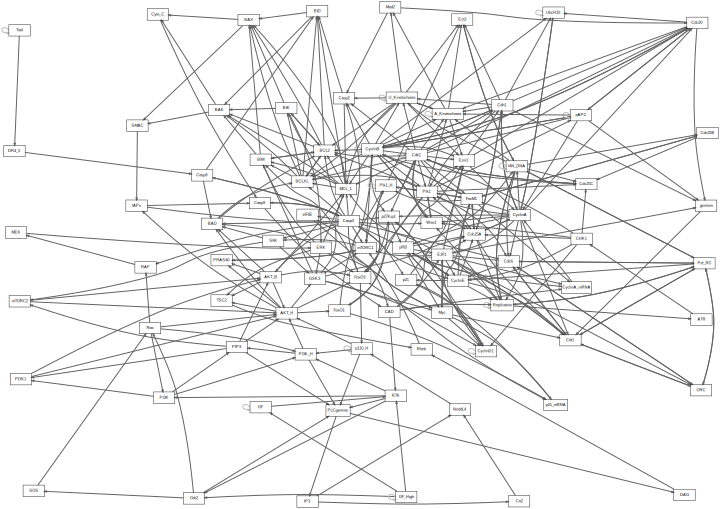

'generic.gv.svg'

In [32]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pSG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pSG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='2.5')

# for nid,SGatt in SG.nodes(data=True):
#     label = SGatt['label']
#     if nid in att:
#         pos = att[nid].get('pos', '')
#         shape = att[nid].get('shape', 'box')
#         fillcolor = colors[att[nid].get('type')]
#         #width = ''att[nid].get('width', '0.7')
#         pSG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor, )
        
for nid,d in SG.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
#     pos = att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pSG.node(str(nid), label=label, ) #pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    # self loop color
    if uid == vid:
        color = '#bdbdbd'
        uid = uid + ':w'
        vid = vid + ':c'
    else:
        color = '#636363'
    pSG.edge(uid, vid, weight=weight, color=color)
    
display(pSG)
pSG.format ='svg'
# Export
pSG.render("generic_graph", cleanup=True) # could obviously extract the network name ... could also
# extract positinos here and force the rest of the graphs to be this look. - that is what I want to do ...

## Effective Graph

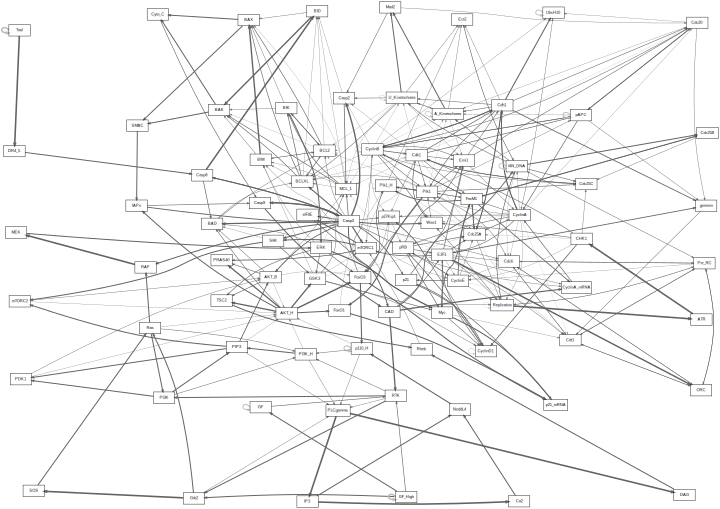

'generic-EG.svg'

In [53]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pEG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='2.5')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)

for nid,d in EG.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
#     pos = att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pEG.node(str(nid), label=label, ) #pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0:       
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')
    
display(pEG)
# Export
pEG.format ='svg'
pEG.render("generic-EG", cleanup=True)

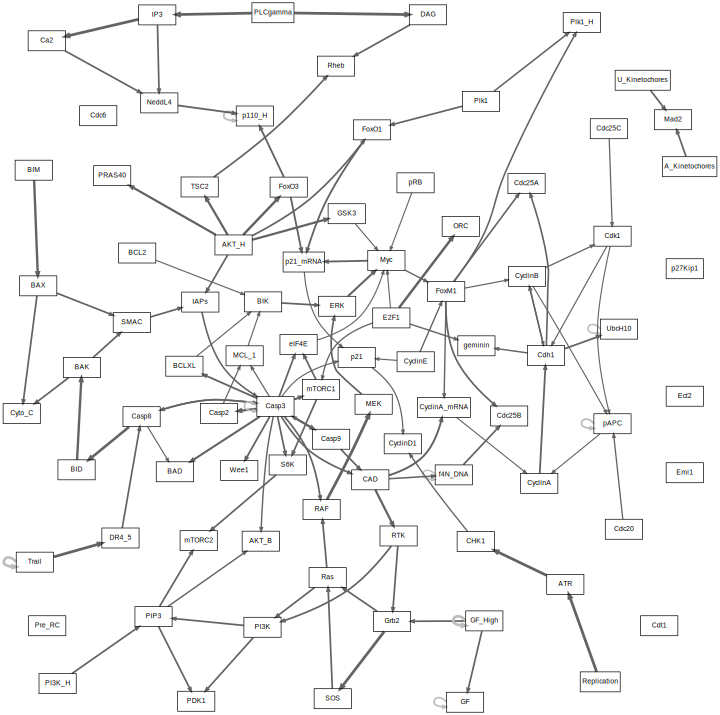

'generic-EGt0p4.svg'

In [82]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pEG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='2.5')

max_effoutdegree = max([v for n,v in EG0p2.out_degree()]) # not sure why the maxeffoutdegree is coming from the 0.20 graph - doesn't seem to make a difference in the graphical output
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)

# Manually position nodes using the DotLayout
# dotpos = nx.drawing.nx_agraph.graphviz_layout(EG, prog='dot', args='-Gconcentrate=false -Gsimplify=false -Goverlap=false -Gsplines=True -Gratio=compress -Goutputorder=edgesfirst -Gnodesep=.25 -Granksep=.20')
#
for nid,d in EG.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
#     x,y = dotpos[nid][0], dotpos[nid][1]
#     pos = '{x:.2f},{y:.2f}'.format(x=x, y=y) #''#att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pEG.node(str(nid), label=label) #, pos=pos)# put postions here!!!


# for nid,d in EG0p4.nodes(data=True):
#     label = d['label']
#     ntype = att[nid].get('type')
#     pos = att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
#     pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in EG0p4.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0.4:       
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')

# NOTE: without per specifying node positions, because the thresholded effective graphs can disconnect the graph
# expect a very different layout compared to the previous graph displays
        
display(pEG)
# Export
pEG.format ='svg'
pEG.render("generic-EGt0p4", cleanup=True)

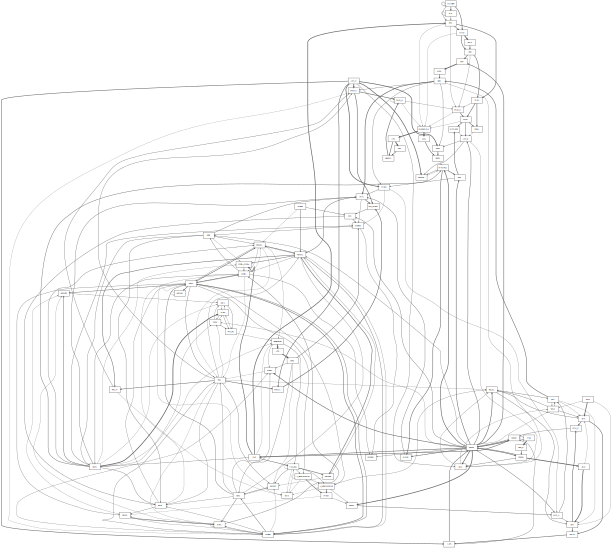

'generic-EGt0p2-dotlayout.svg'

In [63]:
pEG = graphviz.Digraph(name='Structural Graph', engine='dot')
pEG.attr('graph', size='8.5,9', concentrate='false', simplify='false', overlap='false',splines='true',ratio='compress',outputorder="edgesfirst",nodesep='.25',ranksep='.25')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='3')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
cmap = LinearSegmentedColormap.from_list('custom', ['white','#d62728'])
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
#
colornodes = ['Apoptosis', 'Apoptosis_2', 'Apoptosis_3', 'Proliferation', 'Proliferation_2', 'Proliferation_3', 'Proliferation_4']
#
# Manually position nodes using the DotLayout
dotpos = nx.drawing.nx_agraph.graphviz_layout(EG, prog='dot', args='-Gconcentrate=false -Gsimplify=false -Goverlap=false -Gsplines=True -Gratio=compress -Goutputorder=edgesfirst -Gnodesep=.25 -Granksep=.20')
#
for nid,d in EG.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
    x,y = dotpos[nid][0], dotpos[nid][1]
#     pos = '{x:.2f},{y:.2f}'.format(x=x, y=y) #''#att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pEG.node(str(nid), label=label)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] >= 0.2:
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pass
        #pEG.edge(uid,vid, style='dashed', color='#A90533')
 
# Export
display(pEG)
pEG.format ='svg'
pEG.render("generic-EGt0p2-dotlayout", cleanup=True)

In [64]:
# Legend - only makes sense for breast cancer network
# from matplotlib.patches import Patch

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2,2))

# labels = [
#     'RTK signaling',
#     'PI3K pathway',
#     'MAPK pathway',
#     'AKT pathway',
#     'mTORC1 pathway',
#     'ER signaling',
#     'Apoptosis',
#     'Proliferation',
#     'Drugs']

# handles = []
# for label in labels:
#     facecolor = colors[label]
#     patch = Patch(facecolor=facecolor, edgecolor='black', label=label)
#     handles.append(patch)

# leg = ax.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
# plt.axis('off')

# plt.show()

## Dynamic Canalization analysis

### Generic dynamics canalizaiton map (DCM) for network

In [65]:
# Request the DCM to the Network
DCM = C.dynamics_canalization_map(simplify=True)

In [80]:
def draw_canalizing_map_graphviz_custom(DG=None,
                                 on_node_fillcolor='black', on_node_fontcolor='white',
                                 off_node_fillcolor='white', off_node_fontcolor='black',

                                 input_node_bordercolor='gray',
                                 output_node_bordercolor='red',
                                 controlled_node_bordercolor='green',
                                 constant_node_bordercolor='pink',

                                 literal_edge_color='#208120', output_edge_color='#812020',
                                 fusing_edge_color='#a5a5cc', fused_edge_color='#202081',
                                 simplified_edge_color='#cca37a',

                                 fusing_edge_arrowhead='none',
                                 fused_edge_arrowhead='dot',
                                 literal_edge_arrowhead='dot',
                                 out_edge_arrowhead='normal',

                                 simplified_edge_arrowhead='normal',
                                 *args, **kwargs):
    """ Draws the Canalizing Map (CM) using the GraphViz plotting engine.

    Args:
        DG (networkx.DiGraph) : The node Canalizing Map (CM).

    Returns:
        (graphviz) : The network in graphviz dot format.
    """
    G = graphviz.Digraph(engine='dot')
    G.attr('graph', size='9,9', concentrate='false', simplify='false', overlap='false',splines='true',ratio='compress',outputorder="edgesfirst",nodesep='.25',ranksep='.25')
#     G.graph_attr.update(overlap='false')
    G.node_attr.update(fontname='helvetica', shape='box', fontcolor='black', fontsize='12', width='.4', fixedsize='false', style='filled', color='gray', penwidth='3')
    G.edge_attr.update(arrowhead='dot', color='gray', arrowsize='1')

    # Nodes
    for n, d in DG.nodes(data=True):
        if 'type' not in d:
            raise AttributeError("Node type could not be found. Must be either 'variable', 'threshold' or 'fusion'.")

        # Variable Nodes
        if d['type'] == 'variable':

            if 'mode' in d:
                # Border Color. Dependents if 'input', 'output', 'controlled' or 'constant'
                if d['mode'] == 'input':
                    mode_bordercolor = input_node_bordercolor
                elif d['mode'] == 'output':
                    mode_bordercolor = output_node_bordercolor
                elif d['mode'] == 'constant':
                    mode_bordercolor = constant_node_bordercolor
                elif d['mode'] == 'controled':
                    mode_bordercolor = controlled_node_bordercolor
            else:
                mode_bordercolor = output_node_bordercolor

            if d['value'] == 0:
                label = d.get('label', d.get('label-tmp', 'None'))
                G.node(name=n, label=label, fontcolor=off_node_fontcolor, fillcolor=off_node_fillcolor, color=mode_bordercolor)
            elif d['value'] == 1:
                label = d.get('label', d.get('label-tmp', 'None'))
                G.node(name=n, label=label, fontcolor=on_node_fontcolor, fillcolor=on_node_fillcolor, color=mode_bordercolor)

        # Threshold Nodes
        elif d['type'] == 'threshold':
            G.node(name=n, label=d['label'], shape='diamond', style='filled,solid', fillcolor='#dae8f4', fontcolor='black', color='#b5d1e9', width='.4', height='.4')

        elif d['type'] == 'fusion':
            G.node(name=n, label='', shape='none', width='0', height='0', margin='0')

    # Edges
    for s, t, d in DG.edges(data=True):
        color = literal_edge_color
        arrowhead = out_edge_arrowhead

        if 'type' in d:
            if d['type'] == 'out':
                arrowhead = out_edge_arrowhead
                color = output_edge_color

            elif d['type'] == 'literal':
                arrowhead = literal_edge_arrowhead
                color = literal_edge_color

            elif d['type'] == 'fusing':
                arrowhead = fusing_edge_arrowhead
                color = fusing_edge_color

            elif d['type'] == 'fused':
                arrowhead = fused_edge_arrowhead
                color = fused_edge_color

            elif d['type'] == 'simplified':
                if d['mode'] == 'selfloop':
                    arrowhead = simplified_edge_arrowhead
                    color = simplified_edge_color
                elif d['mode'] == 'direct':
                    arrowhead = simplified_edge_arrowhead
                    color = simplified_edge_color

            else:
                raise AttributeError("Node type could not be found. Must be either 'out', 'literal', 'fusing', 'fused' or 'simplified'.  Got {:s}.".format(d['type']))
        G.edge(s, t, arrowhead=arrowhead, color=color)

    return G

In [81]:

#for n,d in DCM.nodes(True):
    #print(n,d)
# Draws using the graphviz interface.
gDCM = draw_canalizing_map_graphviz_custom(DCM)
# Display
# display(gDCM)
gDCM.format ='svg'
gDCM.render("generic-dynamics_canalizing_map_test_dot_2", cleanup=True)

'generic-dynamics_canalizing_map_test_dot_2.svg'

## Explore canalization for node of interest

### Helper function for making schemata

In [100]:
def plot_schemata(n):
    # Init values from BooleanNode
    k = n.k if n.k>=1 else 1
    inputs = n.inputs if not n.constant else [n.name]
    inputlabels = [n.network.get_node_name(i)[0] if n.network is not None else i for i in inputs]
    pi0s = n._prime_implicants.get('0', [])
    pi1s = n._prime_implicants.get('1', [])
    ts0s = n._two_symbols[0]
    ts1s = n._two_symbols[1]
    # Count number of PI and TS
    n_pi = sum(len(pis) for pis in [pi0s,pi1s])
    n_ts = sum(len(tss) for tss in [ts0s,ts1s])
    # Schemata Cell Width and spacing
    cwidth = 60.
    cxspace = 0
    cyspace = 6
    border = 1
    sepcxspace = 21
    sepcyspace = 15
    dpi = 150.
    # Margins
    top, right, bottom, left, hs = 160, 25, 25, 60, 60
    # Axes Width & Height
    ax1width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax1height = (n_pi*(cwidth+cyspace)+sepcyspace-cyspace)
    ax2width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax2height = (n_ts*(cwidth+cyspace)+sepcyspace-cyspace)
    # Figure Width & Height
    fwidth = (left + ax1width + hs + ax2width + right)
    fheight = (bottom + max(ax1height,ax2height) + top)
    # Percentages for Axes location
    _ax1w = ((ax1width*100) / fwidth) / 100
    _ax2w = ((ax2width*100) / fwidth) / 100
    _ax1h = ((ax1height*100) / fheight) / 100
    _ax2h = ((ax2height*100) / fheight) / 100
    _bottom = ((bottom*100) / fheight) / 100
    _left = ((left*100) / fwidth) / 100
    _hs = ((hs*100) / fwidth) / 100
    # Init Figure
    fig = plt.figure(figsize=(fwidth/dpi,fheight/dpi), facecolor='w', dpi=dpi)
    ax1 = fig.add_axes((_left,_bottom,_ax1w,_ax1h), aspect=1, label='PI')
    ax2 = fig.add_axes((_left+_ax1w+_hs,_bottom,_ax2w,_ax1h), aspect=1, label='TS')

    ### PI Plot ###

    yticks = []
    patches = []
    x,y = 0.,0.
    #
    for out,pis in zip([1,0],[pi1s,pi0s]):
        for pi in pis:
            x = 0.
            xticks = []
            for input in pi:
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '#':
                    facecolor = '#cccccc'
                    textcolor = 'black'            
                text = '%s'%(input) if (input!='2') else '#'
                ax1.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='black')
                patches.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='black')
            ax1.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/10*4, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax1.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            patches.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
        y += sepcyspace

    ax1.add_collection(PatchCollection(patches,match_original=True))
    #
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([r"$f^{'}_{%d}$"%(i+1) for i in range(n_pi)[::-1]], fontsize=14)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(inputlabels + ['%s'%(n.name)], rotation=90, fontsize=14)
    #
    ax1.xaxis.tick_top()
    # Remove Tick
    ax1.tick_params(which='major',pad=7)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # Limits
    ax1.set_xlim(-border,ax1width+border)
    ax1.set_ylim(-border,ax1height+border)
    #ax1.invert_yaxis() 

    ## TS ##

    t = 0
    x,y = 0.,0.
    yticks = []
    boxes,symbols = [], []
    #
    tssymbols = [
        Circle((0, 0), radius=5, facecolor='white', edgecolor='black'),
        RegularPolygon((0, 0),numVertices=3, radius=5, orientation=0, facecolor='white', edgecolor='black'),
    ]
    #
    for out,tss in zip([1,0],[ts1s,ts0s]):
        for ts,pss,sss in tss:
            x = 0.
            xticks = []
            for i,input in enumerate(ts):
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '2':
                    facecolor = '#cccccc'
                    textcolor = 'black'

                if len(pss):
                    # TODO: If there are several symbols in the same input position, place them side-by-side
                    iinpss = [j for j,ps in enumerate(pss) if i in ps]
                    xpos = np.linspace(x,x+cwidth, len(iinpss)+2)
                    for z,j in enumerate(iinpss,start=1):
                        s = copy(tssymbols[j])
                        s.xy = (xpos[z],y+cwidth*0.8)
                        s.center = xpos[z],y+cwidth*0.8 # A hack for circles only
                        s.set_edgecolor('#a6a6a6' if (input=='1') else 'black')
                        symbols.append(s)
                        ax2.add_patch(s)

                text = '%s'%(input) if (input!='2') else '#'
                ax2.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='#4c4c4c',zorder=2)
                boxes.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='#4c4c4c')
            ax2.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/2, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax2.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            boxes.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
            t += 1
        y += sepcyspace

    if len(boxes):
        ax2.add_collection(PatchCollection(boxes,match_original=True))
    if len(symbols):
        ax2.add_collection(PatchCollection(symbols,match_original=True))
    #
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([r"$f^{''}_{%d}$"%(i+1) for i in range(n_ts)[::-1]], fontsize=14)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(inputlabels + ['%s'%(n.name)], rotation=90, fontsize=14)
    #
    ax2.xaxis.tick_top()
    # Remove Tick
    ax2.tick_params(which='major',pad=7)
    for tic in ax2.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax2.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Limits
    ax2.set_xlim(-border,ax2width+border)
    ax2.set_ylim(-border,ax2height+border)

    # FileName
    filename = n.name.replace('/','_')
    filename = filename.replace(',','_')
    
    ## Display ##
    display(fig)
    
    plt.close()

## Intended for exploring a node of interest. Not ready yet!!!!!

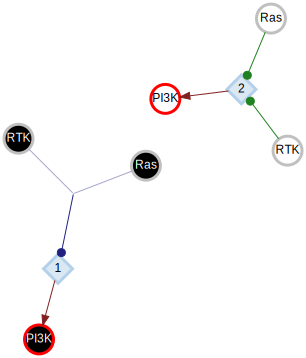

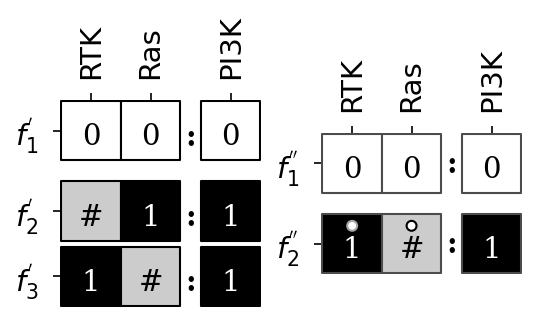

In [101]:
ID_of_node_of_interest = 6

node = C.nodes[ID_of_node_of_interest]

# Make node level effective graph - WIP

# EG0 = C.effective_graph(threshold=0) -- I should be able to calculate the effective connectivity of each edge?
# Actually - I want to extract it from the EG for each node and then plot it node by node - so I have all
# the right information - I just need to get it and then plot it ...

# Make node level canalizing map using the graphviz interface.
gCM = draw_canalizing_map_graphviz(node.canalizing_map())
# Display
display(gCM)

#Calculate and plot schemata
# Compute Prime Implicants & Two-Symbol schematas
node._check_compute_canalization_variables(prime_implicants=True)
node._check_compute_canalization_variables(two_symbols=True)
# Plot
plot_schemata(node)

In [ ]:
def effective_graph_for_node(node, bound='mean', threshold=None):
    """Computes and returns the effective graph of the network.
    In practive it asks each :class:`~cana.boolean_node.BooleanNode` for their :func:`~cana.boolean_node.BooleanNode.edge_effectiveness`.

    Args:
        bound (string) : The bound to which compute input redundancy.
            Can be one of : ["lower", "mean", "upper", "tuple"].
            Defaults to "mean".
        threshold (float) : Only return edges above a certain effective connectivity threshold.
            This is usefull when computing graph measures at diffent levels.

    Returns:
        (networkx.DiGraph) : directed graph

    See Also:
        :func:`~cana.boolean_node.BooleanNode.edge_effectiveness`
    """
    if threshold is not None:
        self._eg = nx.DiGraph(name="Effective Graph: " + self.name + "(Threshold: {threshold:.2f})".format(threshold=threshold))
    else:
        self._eg = nx.DiGraph(name="Effective Graph: " + self.name + "(Threshold: None)")

    # Add Nodes
    for i, node in enumerate(self.nodes, start=0):
        self._eg.add_node(i, **{'label': node.name})

    # Add Edges
    for i, node in enumerate(self.nodes, start=0):
        e_is = node.edge_effectiveness(bound=bound)
        for inputs, e_i in zip(self.logic[i]['in'], e_is):
            # If there is a threshold, only return those number above the threshold. Else, return all edges.
            if (threshold is None) or ((threshold is not None) and (e_i > threshold)):
                self._eg.add_edge(inputs, i, **{'weight': e_i})

    return self._eg



In [ ]:
ID_of_node_of_interest = 6

node = C.nodes[ID_of_node_of_interest]

print(node)

for input in node.inputs:
    print(input)
    print(C.nodes[input].name)
#     print(EG.edges[input])

for edge in EG.edges:
    print(type(edge))

print(type(EG.edges))

# effective_graph_for_node = nx.DiGraph(name="Effective Graph: " + node.name + "(Threshold: None)")

# effective_graph_for_node.add_node(node, **{'label': node.name})

# for input_node in node.inputs:
#     print(input_node)
#     effective_graph_for_node.add_node(input_node, **{'label': C.nodes[input_node].name})

# effective_graph_for_node.add_edge(node.inputs, 0)

# e_is = node.edge_effectiveness()
# e_is